# Comparación de Multiplicación de Matrices: NumPy vs DPNP

En este cuaderno, comparamos el rendimiento de la multiplicación de matrices utilizando **NumPy** y **DPNP**. DPNP es una biblioteca optimizada para hardware moderno que puede aprovechar la aceleración de GPU, proporcionando mejoras significativas en el tiempo de ejecución.

### ¿Por qué usar DPNP?
- **Aprovecha la aceleración por GPU** para cálculos más rápidos.
- **Compatibilidad con NumPy**, lo que permite migrar código con cambios mínimos.
- **Ideal para grandes volúmenes de datos**, especialmente en aprendizaje automático y simulaciones científicas.

### Ejemplo de Multiplicación de matrices usando **numpy.dot**
* La función `matrix_multiplication_numpy` realiza la multiplicación de matrices de forma ordinaria empleando numpy
* La función `matrix_multiplication_dpnp` realiza el proceso equivalente con **DPNP**, el parámetro de entrada referido a la variable `dev` indica el dispositivo donde se ejecuta. Cambiarlo por "cpu" y "gpu" para verificar los tiempos y speedups 

In [38]:
import numpy as np
import dpnp as np_dp
import time

def matrix_multiplication_numpy():
    size = 8192
    a = np.random.rand(size, size).astype(np.float32)
    b = np.random.rand(size, size).astype(np.float32)
    
    start_time = time.time()
    c = np.dot(a, b)
    end_time = time.time()
    
    print("Matrix multiplication (NumPy) completed.")
    print("Time taken (NumPy):", end_time - start_time, "seconds\n")

    return end_time - start_time

def matrix_multiplication_dpnp(dev):

    if (dev=='cpu'):
        d = dpctl.select_cpu_device()
    elif (dev=='gpu'):
        d = dpctl.select_gpu_device()        
    d.print_device_info()
    
    size = 8192
    a = np.random.rand(size, size).astype(np.float32)
    a_xpu = np_dp.asarray(a, device=dev)
    b = np.random.rand(size, size).astype(np.float32)
    b_xpu = np_dp.asarray(b, device=dev)
        
    start_time = time.time()
    c = np_dp.dot(a_xpu, b_xpu)

    _ = c.asnumpy()  #Ensure all computations are completed
    end_time = time.time()
    
    print(f"Matrix multiplication (DPNP on {dev}) completed.")
    print(f"Time taken (DPNP on {dev}):", end_time - start_time, "seconds")
    print("DPNP harnesses GPU acceleration for enhanced performance! Give it a try!")
    return end_time - start_time

if __name__ == "__main__":
    print("Benchmarking NumPy vs DPNP for Matrix Multiplication\n")
    t_np = matrix_multiplication_numpy()

    t_xpu = matrix_multiplication_dpnp("cpu")
    print(f"\nSpeed-up=", np.round(t_np/t_xpu, 1), "x")

Benchmarking NumPy vs DPNP for Matrix Multiplication

Matrix multiplication (NumPy) completed.
Time taken (NumPy): 1.2626287937164307 seconds

    Name            Intel(R) Xeon(R) Platinum 8468V
    Driver version  2024.18.12.0.05_160000
    Vendor          Intel(R) Corporation
    Filter string   opencl:cpu:0

Matrix multiplication (DPNP on cpu) completed.
Time taken (DPNP on cpu): 1.1050891876220703 seconds
DPNP harnesses GPU acceleration for enhanced performance! Give it a try!

Speed-up= 1.1 x


# Ejercicio 1 (calculo de $\pi$ mediante el Método de Monte Carlo)

El método de **Monte Carlo** es una técnica probabilística utilizada para estimar el valor de π generando puntos aleatorios dentro de un cuadrado y determinando cuántos caen dentro de un círculo inscrito.

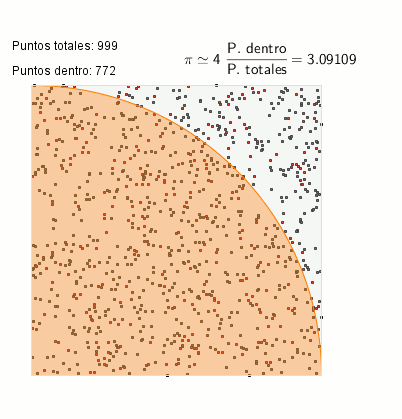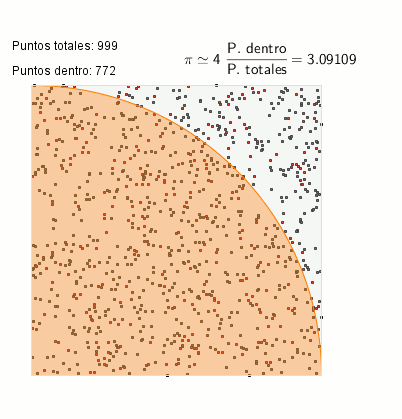

## **Concepto del Método**
Consideremos un círculo de radio **r = 1** inscrito dentro de un cuadrado de lado **2r = 2**. La ecuación del círculo centrado en el origen es:

$ x^2 + y^2 \leq r^2 $

Dado que el área del cuadrado es **4** y el área del círculo es **π**, la proporción de puntos dentro del círculo respecto al total de puntos generados aleatoriamente será aproximadamente:

$ \frac{\text{puntos dentro en el círculo}}{\text{puntos totales}} \approx \frac{\pi}{4} $

De aquí, podemos despejar **π** como:

$ \pi \approx 4 \times \frac{\text{puntos dentro en el círculo}}{\text{puntos totales}} $

## ToDo¶
Implementar la ver versión equivalente empleando DPNP

In [41]:
import numpy as np
import time

def main(N, dtypefp):
    if dtypefp=='float32':
        size_dtypefp = np.dtype(np.float32).itemsize
        npfloat = np.float32
    else: 
        size_dtypefp = np.dtype(np.float64).itemsize
        npfloat = np.float64

    np.random.seed(17) # set the random number generator seed

    x = np.random.random(N)
    y = np.random.random(N)

    t1 = time.perf_counter()
    z = np.multiply(x, x) + np.multiply(y,y)
    hits = np.count_nonzero(z <=1.0)
    my_pi = 4.0*hits/N
    t2 = time.perf_counter()
    print("N={}  pi={}".format(N, my_pi))
    print("calc_pi took {} s.".format(t2-t1))


if __name__ == "__main__":
    main(N=1_000_000_000, dtypefp='float32')

N=1000000000  pi=3.141584932
calc_pi took 3.2524741299566813 s.


In [42]:
# To Do

# Ejercicio 2 (nbody)
Este código implementa una **simulación N-cuerpos** utilizando la **Ley de Gravitación Universal de Newton**. El objetivo es calcular las fuerzas gravitatorias entre múltiples cuerpos y actualizar sus velocidades y posiciones a lo largo del tiempo.

## Componentes Claves del Código
1. Función `bodyForce`
Esta función calcula la aceleración gravitatoria en cada cuerpo debido a la atracción de los demás cuerpos. 
- Calcula la distancia entre cada par de cuerpos.
- Usa **suavizado (softening)** para evitar singularidades cuando las distancias son muy pequeñas.
- Actualiza las componentes de velocidad (`velx`, `vely`, `velz`) en función de las aceleraciones calculadas.

2. Función `integrate`
- Actualiza las posiciones de los cuerpos utilizando sus velocidades.
- Implementa un paso de integración simple usando **Euler**.

3. Función `solutionPos`
- Calcula una métrica global del sistema sumando las distancias de todos los cuerpos respecto al origen.

4. Función `main`
- Inicializa los parámetros de la simulación:
  - **Número de cuerpos (`N`)** y **número de iteraciones (`iters`)**.
  - Masas, posiciones iniciales y velocidades.
  - **Constante de Gravitación de Newton (`G`)**.
  - **Factor de suavizado** para evitar inestabilidad numérica.
- Ejecuta la simulación durante el número de iteraciones especificado.
- Mide el rendimiento del algoritmo:
  - **Millones de interacciones por segundo**.
  - **Tiempo total de ejecución**.
  - **Métrica final de la posición del sistema**.

## **Consideraciones de Rendimiento**
- El algoritmo tiene una **complejidad de O(N²)**, lo que significa que el costo computacional crece cuadráticamente con el número de cuerpos.
- Utiliza **operaciones NumPy** para mejorar la eficiencia.
- El **factor de suavizado (`softeningSquared`)** evita valores infinitos debido a divisiones por cero.

## ToDo
- Implementar la ver versión equivalente empleando DPNP


In [28]:
import numpy as np
import time

def bodyForce( mass, x, y, z, velx, vely, velz, G, dt, softeningSquared ):

    for i in range(len(x)):
        dx = x[i] - x
        dy = y[i] - y
        dz = z[i] - z
                
        distSqr = (dx*dx + dy*dy + dz*dz + softeningSquared)
        invDist = 1/distSqr
        invDist3 = invDist * invDist * invDist
        
        g_mass = np.multiply(G,mass)
        g_mass[i] = 0 # To invalidate itself

        ax = np.sum(g_mass * dx * invDist3)
        ay = np.sum(g_mass * dy * invDist3)
        az = np.sum(g_mass * dz * invDist3)

        velx[i] = dt*ax
        vely[i] = dt*ay
        velz[i] = dt*az
	
def integrate( x, y, z, velx, vely, velz, dt ):
    x = x + velx*dt
    y = y + vely*dt
    z = z + velz*dt
	
	
def solutionPos( x, y, z ):
    pos_global = np.sum(np.sqrt(x*x+y*y+z*z))	
    return(pos_global)

def main(N, iters, dtypefp):
    if dtypefp=='float32':
        size_dtypefp = np.dtype(np.float32).itemsize
        npfloat = np.float32
    else: 
        size_dtypefp = np.dtype(np.float64).itemsize
        npfloat = np.float64

    np.random.seed(17)                            # set the random number generator seed
    softSqred = npfloat(0.001)                    # softening length
    G         = npfloat(6.674e-11)                # Newton's Gravitational Constant
    mass  = 20*np.ones(N, dtype=npfloat)/N        # total mass of particles is 20
    posx  = np.random.randn(N).astype(npfloat)    # randomly selected positions and velocities
    posy  = np.random.randn(N).astype(npfloat)
    posz  = np.random.randn(N).astype(npfloat)
    velx  = np.zeros(N, dtype=npfloat)
    vely  = np.zeros(N, dtype=npfloat)
    velz  = np.zeros(N, dtype=npfloat)

    dt = npfloat(0.1)

    t0 = time.time()
    for iter in range(iters):
        # calculate gravitational accelerations
        bodyForce(mass, posx, posy, posz, velx, vely, velz, G, dt, softSqred)
        integrate(posx, posy, posz, velx, vely, velz, dt)
    
    t1 = time.time()
    totalTime = t1-t0

    print("{} Bodies with {} iterations. {:.2f} Millions Interactions/second".format(N, iters, 1e-6*iters*N*N/totalTime))
    print("nbody took {:4.2f} s.".format(totalTime))

    print('pos={}'.format(solutionPos(posx, posy, posz)))

if __name__ == "__main__":
    main(N=1000, iters=100, dtypefp='float32')

1000 Bodies with 100 iterations. 32.93 Millions Interactions/second
nbody took 3.04 s.
pos=1589.67724609375
